In [1]:
import pandas as pd

# load data
df = pd.read_csv('../Data/SMTO_2015/SMTO_2015_Complete_Input.csv')
df = df[df['Level'] != 'Other']
df.head()

,Campus,Level,Status,Mode_Actual,Gender,Licence,Work,Age,HomeZone,Family,...,Domestic.OC,Admission_Avg.SG,Admission_Avg.SC,Admission_Avg.MI,Admission_Avg.YK,Admission_Avg.YG,Admission_Avg.RY,Admission_Avg.OC,Exp_Segment,Exp_Level
0,Scarborough (UTSC),UG,FT,Transit Bus,Female,0,Unknown,20,261,1,...,0.8998,0.893,0.841,0.83,0.817,0.817,0.84,0.824,0.944738,0.944738
1,Downtown Toronto (St. George),Grad,FT,Walk,Female,1,Unknown,25,71,0,...,0.6786,0.893,0.841,0.83,0.817,0.817,0.84,0.824,0.986085,0.986085
2,Downtown Toronto (St. George),UG,FT,Transit Bus,Female,1,Unknown,23,3714,1,...,0.8998,0.893,0.841,0.83,0.817,0.817,0.84,0.824,0.919270,0.919270
3,Downtown Toronto (St. George),UG,FT,Walk,Male,1,Unknown,20,74,0,...,0.8998,0.893,0.841,0.83,0.817,0.817,0.84,0.824,0.919270,0.919270
4,Downtown Toronto (St. George),Grad,FT,Walk,Male,1,Unknown,27,71,0,...,0.6786,0.893,0.841,0.83,0.817,0.817,0.84,0.824,0.986085,0.986085


In [2]:
# Load zone coordinates
zones = pd.read_csv('../Data/Zones.csv')
zones.set_index('Zone#', inplace=True)
zones.corr()

,PD,X,Y
PD,1.000000,-0.456036,-0.371999
X,-0.456036,1.000000,0.633247
Y,-0.371999,0.633247,1.000000


In [3]:
# Add zone information to df
temp = pd.DataFrame([[a[i] for a in (zones['PD'], zones['X'], zones['Y'])] for i in df['HomeZone']], columns=['PD', 'X', 'Y'], index=df.index)
df = pd.concat((df, temp), axis=1)

# Normalize from 0 to 1
df['X'] = (df['X'] - df['X'].min()) / (df['X'].max() - df['X'].min())
df['Y'] = (df['Y'] - df['Y'].min()) / (df['Y'].max() - df['Y'].min())

df[['X', 'Y']].describe()

,X,Y
count,14357.000000,14357.000000
mean,0.414098,0.477093
std,0.105181,0.086133
min,0.000000,0.000000
25%,0.369961,0.434447
50%,0.434493,0.459694
75%,0.459581,0.529216
max,1.000000,1.000000


In [4]:
import math

def cartesian_to_radius(x, y):
    return math.sqrt(x*x + y*y)
def cartesian_to_angle(x, y):
    return math.atan2(y, x)
def polar_to_x(r, theta):
    return r * math.cos(theta)
def polar_to_y(r, theta):
    return r * math.sin(theta)

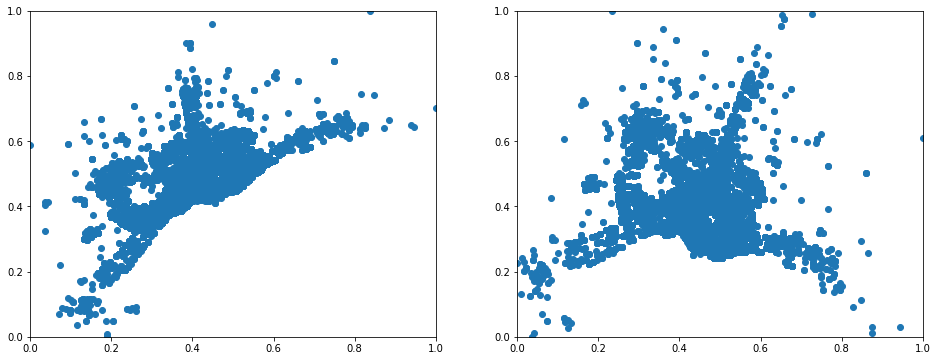

In [5]:
import matplotlib.pyplot as plt

plt.subplots(1, 2, figsize=(16, 6))

# Plot original coordinates
plt.subplot(1, 2, 1)
plt.scatter(df['X'], df['Y'])
plt.xlim(0, 1)
plt.ylim(0, 1)

# Rotate coordinates
shift = 40 # Degrees
df['R'] = df.apply(lambda z: cartesian_to_radius(z.X, z.Y), axis=1)
df['Theta'] = df.apply(lambda z: cartesian_to_angle(z.X, z.Y), axis=1)
df['Theta2'] = df['Theta'] - shift * math.pi / 180
df['X2'] = df.apply(lambda z: polar_to_x(z.R, z.Theta2), axis=1)
df['Y2'] = df.apply(lambda z: polar_to_y(z.R, z.Theta2), axis=1)

# Normalize new coordinates
df['X2'] = (df['X2'] - df['X2'].min()) / (df['X2'].max() - df['X2'].min())
df['Y2'] = (df['Y2'] - df['Y2'].min()) / (df['Y2'].max() - df['Y2'].min())

# Plot new coordinates
plt.subplot(1, 2, 2)
plt.scatter(df['X2'], df['Y2'])
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.show()

In [6]:
# Machine learning packages
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import matthews_corrcoef

def average(l):
    return sum(l) / len(l)

In [7]:
std_dists = df.iloc[:, 17:24]
dist_flags = df.iloc[:, 89:95]
same_zone_flags = df.iloc[:, 96:101]
four_dists = df.iloc[:, 17:21] # No OC, RY, YG
five_dists = df.iloc[:, 17:22] # No OC, RY
coords = df[['X', 'Y']]
new_coords = df[['X2', 'Y2']]

In [8]:
# Prepare results dataframe
metric_names = ['Acc', 'Prec', 'Rec', 'F1', 'MCC', 'APO']
results = pd.DataFrame(columns=['Model', 'Trials'] + metric_names)

In [9]:
# Prepare classifier
rf = RandomForestClassifier(n_estimators=100, max_depth=5)
y = df['School_Codes']
num_trials = 10

# Run models
for x_temp, name in ((coords, 'Coords'), (new_coords, 'NewCoords')):
    # Prepare metrics
    metrics = {}
    for metric in metric_names:
        metrics[metric] = []
    
    # Run trials
    for i in range(num_trials):
        # Split data and run model
        X_train, X_test, y_train, y_test = train_test_split(x_temp, y, test_size=0.3)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
        
        # Metrics
        metrics['Acc'].append(rf.score(X_test, y_test))
        [a.append(b) for a,b in zip([metrics['Prec'], metrics['Rec'], metrics['F1']], precision_recall_fscore_support(y_test, y_pred, average = 'macro')[:3])]
        metrics['MCC'].append(matthews_corrcoef(y_test, y_pred))
        
        # APO
        schools = list(rf.classes_)
        probs = pd.concat((y_test.reset_index(drop=True), pd.DataFrame(rf.predict_proba(X_test))), axis=1)
        metrics['APO'].append(probs.apply(lambda z: z[schools.index(z.School_Codes)], axis=1).mean())
    
    # Add results to dataframe
    ave_metrics = [average(v) for v in metrics.values()]
    results.loc[len(results)] = [name, num_trials] + ave_metrics

C:\Users\ethan\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ethan\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ethan\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ethan\anaconda3\lib\site-packages\sklearn\metr

In [10]:
pd.DataFrame({'Features' : x_temp.columns, 'Importance': rf.feature_importances_}).sort_values('Importance', ascending=False)

,Features,Importance
0,X2,0.504523
1,Y2,0.495477


In [11]:
# Visualization code from https://towardsdatascience.com/how-to-visualize-a-decision-tree-from-a-random-forest-in-python-using-scikit-learn-38ad2d75f21c
from sklearn.tree import export_graphviz

# Export a tree as .dot file
tree = rf.estimators_[32]
export_graphviz(tree, out_file='tree.dot', feature_names = x_temp.columns, class_names = rf.classes_, rounded = True, proportion = False, precision = 3, filled = True)

# Convert to .png file
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'], shell=True)

# Display tree
from IPython.display import Image
Image(filename = 'tree.png')

In [12]:
# Results by model
results.groupby('Model').mean().sort_values('APO', ascending=False)

,Acc,Prec,Rec,F1,MCC,APO
Model,,,,,,
Coords,0.497238,0.338876,0.319301,0.290566,0.290214,0.365507
NewCoords,0.490460,0.389485,0.305567,0.283415,0.275134,0.361171
